In [1]:
# Import Modules 

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval

!pip install plotly.express
import plotly.express as px
# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline and Column Transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
set_config(display = "diagram")

# Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# Cross Validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# Unsupervised Learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

In [2]:
# Loading Dataset

%load_ext autoreload
%autoreload 2

data = pd.read_csv("../raw_data/Recipes_incl_pre_time.csv")

data.Relabelled_Ingredients = data.Relabelled_Ingredients.apply(literal_eval)
data['Instructions'] = data.Instructions.apply(str)
data = data.drop(columns=['Unnamed: 0.1'])

In [3]:
#Creating metrics

data['number_of_ingredients'] = data.apply(lambda x: len(x['Relabelled_Ingredients']), axis = 1 )
data['length_of_instructions'] = data.apply(lambda x: len(x['Instructions']), axis = 1 )



In [4]:
X = data[['number_of_ingredients','length_of_instructions']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7873 entries, 0 to 7872
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   number_of_ingredients   7873 non-null   int64
 1   length_of_instructions  7873 non-null   int64
dtypes: int64(2)
memory usage: 123.1 KB


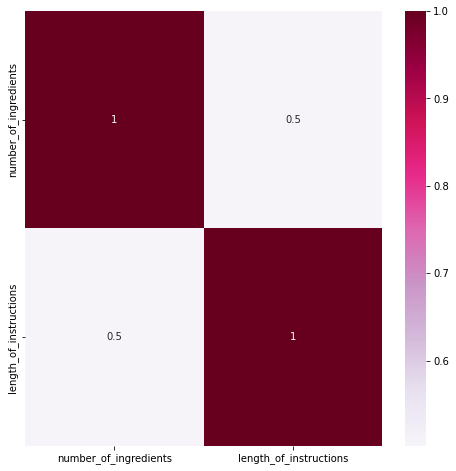

In [5]:
X.info()

plt.figure(figsize=(8,8))

sns.heatmap(X.corr(),
            annot = True,
            annot_kws = {"fontsize":10},
            cmap='PuRd');

In [6]:
kmeans_vanilla = KMeans(n_clusters = 5)
kmeans_vanilla.fit(X)
 
labels_vanilla = kmeans_vanilla.labels_
labels_vanilla


array([1, 3, 1, ..., 3, 3, 0], dtype=int32)

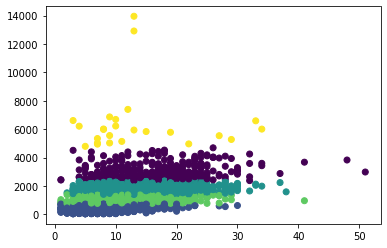

In [8]:

plt.scatter(x = X['number_of_ingredients'],y= X['length_of_instructions'] , c=labels_vanilla)

## Scaling

In [9]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled

,number_of_ingredients,length_of_instructions
0,-0.500000,-0.319549
1,0.000000,-0.007519
2,-0.666667,-0.745614
3,-1.000000,-0.644110
4,-0.500000,-0.289474
...,...,...
7868,0.833333,1.002506
7869,0.500000,-0.228070
7870,-0.500000,-0.013784
7871,-0.666667,0.542607


In [10]:
kmeans_vanilla2 = KMeans(n_clusters = 5)
kmeans_vanilla2.fit(X_scaled)
 
labels_vanilla2 = kmeans_vanilla2.labels_
labels_vanilla2


array([3, 4, 3, ..., 3, 0, 1], dtype=int32)

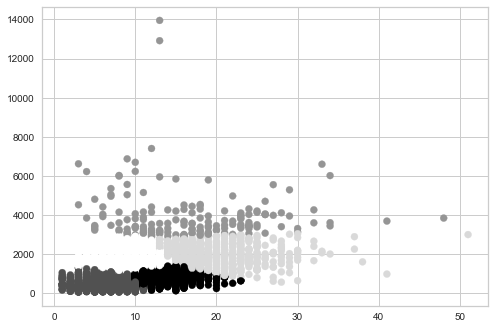

In [28]:
plt.scatter(x = X['number_of_ingredients'],y= X['length_of_instructions'] , c=labels_vanilla2)

## PCA

In [12]:
pca = PCA()
pca.fit(X_scaled) # find all the Principal Components PC (no y!)

PCA()

In [13]:
threhsold_pca = 2
pca = PCA(n_components=threhsold_pca, whiten=True)
pca.fit(X_scaled)
X_proj = pd.DataFrame(pca.transform(X_scaled))
X_proj

,0,1
0,-0.724274,0.256385
1,-0.218523,-0.075407
2,-1.126191,0.048583
3,-1.239103,0.575789
4,-0.702484,0.286119
...,...,...
7868,0.979389,-0.143982
7869,-0.098637,-0.933736
7870,-0.502742,0.558679
7871,-0.192854,1.322181


In [14]:
kmeans_pca = KMeans(n_clusters = 5)
kmeans_pca.fit(X_proj)
labels_kmeans_pca = kmeans_pca.labels_
labels_kmeans_pca

array([2, 1, 2, ..., 2, 0, 4], dtype=int32)

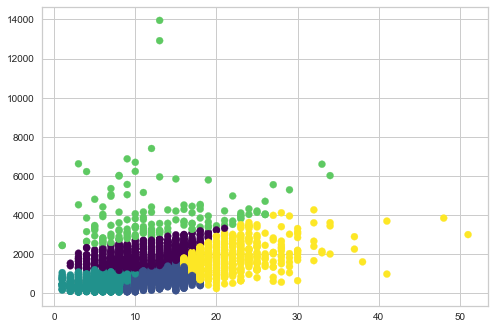

In [31]:
plt.scatter(x = X['number_of_ingredients'],y= X['length_of_instructions'] , c=labels_kmeans_pca, cmap="viridis")

## Ideal Numbers of Clusters

In [16]:
nb_clusters_to_try = np.arange(1,20+1,1)
nb_clusters_to_try

# Apply the elbow method to find the optimal number of clusters.

wcss = []

for K in nb_clusters_to_try:
    print('working with ' + str(K) + ' clusters...', flush=True)
    kmeans = KMeans(n_clusters = K)
    kmeans.fit(X_proj)
    wcss.append(kmeans.inertia_)
print("DONE !")

working with 1 clusters...
working with 2 clusters...
working with 3 clusters...
working with 4 clusters...
working with 5 clusters...
working with 6 clusters...
working with 7 clusters...
working with 8 clusters...
working with 9 clusters...
working with 10 clusters...
working with 11 clusters...
working with 12 clusters...
working with 13 clusters...
working with 14 clusters...
working with 15 clusters...
working with 16 clusters...
working with 17 clusters...
working with 18 clusters...
working with 19 clusters...
working with 20 clusters...
DONE !


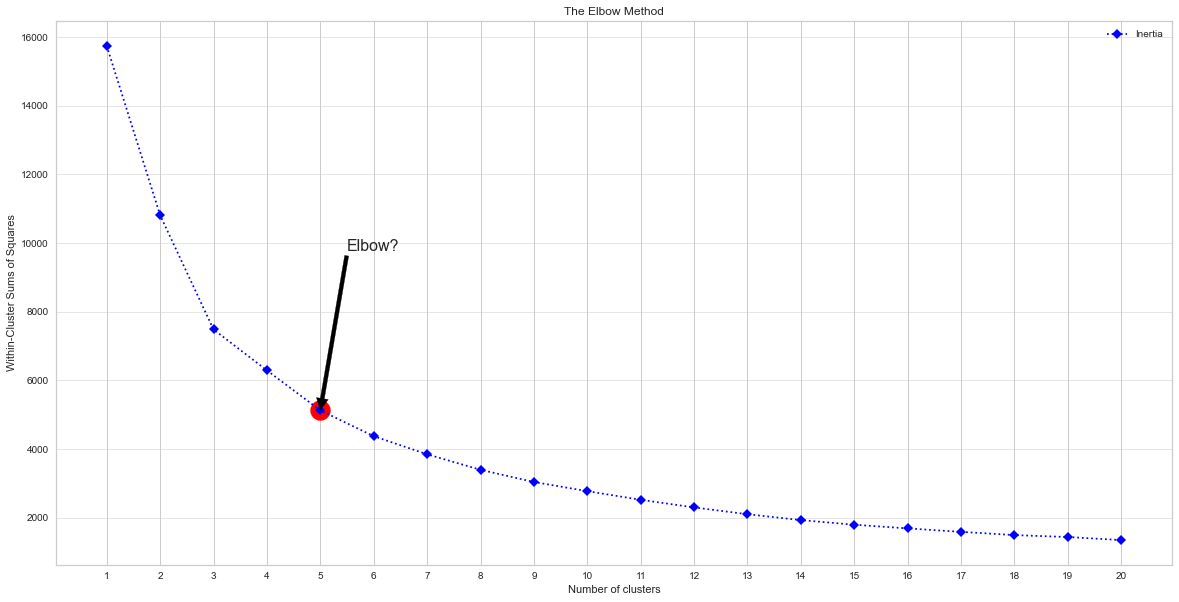

In [20]:
elbow_highlight = 5
with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(20,10))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(nb_clusters_to_try, wcss,color="blue",linestyle=":",marker="D",label="Inertia")
    # customizing
    ax.legend(loc="upper right")
    ax.set_title('The Elbow Method')
    ax.set_xticks(nb_clusters_to_try)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Within-Cluster Sums of Squares')
    ax.scatter(elbow_highlight,wcss[elbow_highlight-1],c='red',s=400)    
    # annotate
    ax.annotate("Elbow?", 
                (elbow_highlight,wcss[elbow_highlight-1]),
                (elbow_highlight+0.50,wcss[elbow_highlight-1]+5000), 
                arrowprops=dict(facecolor='black'),
                fontsize=16,
#                horizontalalignment='middle', 
                verticalalignment='top')
    
    ax.grid(axis="y",linewidth=0.5)
    plt.show()

In [18]:
!pip install yellowbrick
!pip install --upgrade yellowbrick
from yellowbrick.cluster import KElbowVisualizer


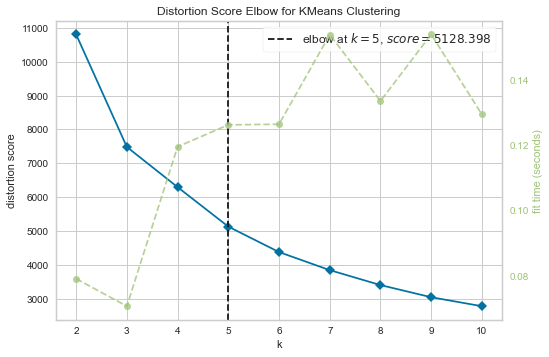

In [19]:

kmeans = KMeans()
elbow_visualizer = KElbowVisualizer(kmeans, n_clusters = (1,21))
elbow_visualizer.fit(X_proj)
elbow_visualizer.show();

## Final Clustering and Merge

Working with 10 clusters
--------------------------------------------------------------------------------


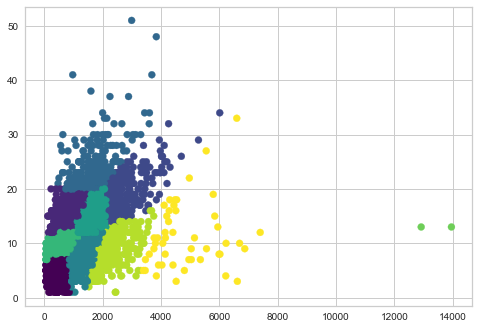

In [45]:
recipes_clusters = 10

print('Working with ' + str(recipes_clusters) + ' clusters', flush=True)
print("-"*80)

kmeans = KMeans(n_clusters = recipes_clusters, max_iter = 300)

kmeans.fit(X_proj)

labelling = kmeans.labels_


plt.scatter(x = X['length_of_instructions'],y= X['number_of_ingredients'] , c=labelling, cmap='viridis')


In [34]:
X_labelled = pd.concat([X,pd.Series(labelling)],axis=1).rename(columns={0:"label"})
X_labelled

,number_of_ingredients,length_of_instructions,label
0,7,613,0
1,10,862,0
2,6,273,0
3,4,354,0
4,7,637,0
...,...,...,...
7868,15,1668,1
7869,13,686,1
7870,7,857,0
7871,6,1301,0


In [35]:
X_labelled['label'].value_counts()

0    4514
1    2431
2     928
Name: label, dtype: int64

In [36]:
X_labelled.groupby(by="label", dropna=False).mean()

,number_of_ingredients,length_of_instructions
label,,
0,7.569118,682.034781
1,15.767585,1174.112299
2,12.264009,2391.995690


In [ ]:
X_labelled